In [1]:
import pickle as pk
import matplotlib.pylab as plt
import numpy as np
from numpy.linalg import norm
from math import sqrt, exp
%matplotlib nbagg
from PyKEP import *
import seaborn as sns
sns.set_style("whitegrid")

import sklearn
from sklearn import *
import pandas as pd
import lasagne
import theano
import theano.tensor as T
import tqdm

/usr/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/home/joerg/venv/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/home/joerg/venv/lib/python3.5/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

We load the data file obtained from the optimization (in low-thrust) of many legs (GTOC7): 

ast1, ast2, $t_1$, $t_2$, $m^*$, $m_i$, $\Delta V^*$, $\Delta V$, $\Delta V_L$, $\Delta V_D$, $m^*_L$, $m^*_D$

We want to learn $\Delta V$ (i.e. the final mass) from the rest (known quickly using a Lambert solver and Damon model). The ast1 and ast2 ids can be used with the gtoc7 asteroids to know the orbitalparameters.


In [3]:
a = pk.load(open("learn.pkl","rb"))
data = pd.DataFrame(a, columns=['ast1', 'ast2', 't1', 't2', 'm_star', 'm_initial', 'dv_star',
                                'dv_optimal', 'dv_lambert', 'dv_damon', 'm_star_lambert', 'm_star_damon'])

data.iloc[0]

ast1              11830.000000
ast2              10256.000000
t1                10962.602365
t2                11220.658170
m_star             1427.649649
m_initial          1352.561644
dv_star            4894.912247
dv_optimal         4225.217792
dv_lambert         2629.037470
dv_damon           4906.746184
m_star_lambert     2544.203547
m_star_damon       1476.601039
Name: 0, dtype: float64

## Now we do some machine learning

From each line ast1, ast2, $t_1$, $t_2$, $m^*$, $m_i$, $\Delta V^*$, $\Delta V$, $\Delta V_L$, $\Delta V_D$, $m^*_L$, $m^*_D$

As attributes we use $t_2-t_1$, $m^*_D$, $m_i$, $\Delta V^*_D$, $\Delta V_L$, $m^*_L$, as these are the ones we can compute at the cost of one lambert problem solution


### Feature Engineering using PyKEP

In [4]:
def comp_v_inf(r1, r2, v1, v2, t):
    l = lambert_problem(r1, r2, t, MU_SUN, False, 1)
    v1_inf = l.get_v1()[0] - v1
    v2_inf = l.get_v2()[0] - v2
    return np.hstack((v1_inf, v2_inf))

In [5]:
def compute_m_D_star(v1_inf, v2_inf, DeltaT, T_max, I_sp, g_0):
    v2p1 = v2_inf + v1_inf
    v2m1 = v2_inf - v1_inf
    
    alpha = np.sum(v2p1 * v2p1, axis=1) / np.sum(v2p1 * v2m1, axis=1)
    
    tau = 0.5 * (alpha + 1 - np.sign(alpha) * np.sqrt(1 + alpha**2))
    
    # aD = damon(v1_inf, v2_inf, DeltaT)[-1] / DeltaT # this function is not vectorized
    aD = norm((v2m1.transpose() * tau - v2p1.transpose()) / (tau * DeltaT), axis=0)
    
    return 2 * T_max / aD / (1 + np.exp((-aD * DeltaT) / (I_sp * g_0)))

In [6]:
# a, e, i, Omega, omega, M
orbital_elements = np.array([(
        planet.gtoc7(int(ast1)).osculating_elements(epoch(0)),
        planet.gtoc7(int(ast2)).osculating_elements(epoch(0)),
    ) for ast1, ast2 in zip(data['ast1'], data['ast2'])])

rv = np.array([(
        planet.gtoc7(int(ast1)).eph(t1),
        planet.gtoc7(int(ast2)).eph(t2)
    ) for ast1, ast2, t1, t2 in zip(data['ast1'], data['ast2'], data['t1'], data['t2'])])

a1 = orbital_elements[:, 0, 0]
a2 = orbital_elements[:, 1, 0]

r1 = rv[:, 0, 0, :]
v1 = rv[:, 0, 1, :]
r2 = rv[:, 1, 0, :]
v2 = rv[:, 1, 1, :]

In [7]:
n1 = np.sqrt(MU_SUN/a1**3)
n2 = np.sqrt(MU_SUN/a2**3)

h1 = np.cross(r1, v1)
h2 = np.cross(r2, v2)

cost = np.sum(h1 * h2, axis=1) / norm(h1, axis=1) / norm(h2, axis=1)

DeltaT = (a[:, 3] - a[:, 2]) * DAY2SEC

v_inf = np.array([comp_v_inf(rve[0, 0, :], rve[1, 0, :], rve[0, 1, :], rve[1, 1, :], dt) for rve, dt in zip(rv, DeltaT)])

v1_inf = v_inf[:, :3]
v2_inf = v_inf[:, 3:]

In [8]:
T_max = 0.3
I_sp = 3000
g_0 = 9.80665

#m_D_star = compute_m_D_star(v1_inf, v2_inf, DeltaT, T_max, I_sp, g_0) # this value should equal to data['m_star_damon']

m_final = data['m_initial'] * (1 - np.exp(-data['dv_optimal'] / I_sp / g_0))

In [9]:
base_features = np.vstack((DeltaT, cost, norm(r1, axis=1), norm(r2, axis=1),
                           norm(v1_inf, axis=1), norm(v2_inf, axis=1), norm(v1, axis=1), norm(v2, axis=1)))
base_features = np.hstack((base_features.transpose(), v_inf,
                           data[['dv_lambert', 'dv_damon', 'm_star_lambert', 'm_star_damon']],
                           rv.reshape(-1, 3 * 4), orbital_elements.reshape(-1, 2 * 6)))

### compose training data

In [10]:
X = np.hstack((base_features, data[['m_initial', 'm_star']]))

#y = data['m_star']
y = m_final

In [11]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

### Test all regressors

In [12]:
regressors = [
#    sklearn.linear_model.LinearRegression(),
#    sklearn.linear_model.PassiveAggressiveRegressor(),
#    sklearn.linear_model.RANSACRegressor(),
#    sklearn.linear_model.SGDRegressor(),
#    sklearn.linear_model.TheilSenRegressor(),
    #sklearn.linear_model.ARDRegression(), # out of memory...
#    sklearn.linear_model.BayesianRidge(),
#    sklearn.linear_model.ElasticNet(),
#    sklearn.linear_model.Lars(),
#    sklearn.linear_model.Lasso(),
    #sklearn.neighbors.RadiusNeighborsRegressor(), # out of memory...
#    sklearn.neighbors.KNeighborsRegressor(),
#    sklearn.tree.DecisionTreeRegressor(),#min_samples_split=13, min_samples_leaf=5),
#    sklearn.ensemble.ExtraTreesRegressor(),
#    sklearn.ensemble.AdaBoostRegressor(),
    sklearn.ensemble.GradientBoostingRegressor(max_depth=8),
#    sklearn.ensemble.BaggingRegressor(),
#    sklearn.ensemble.RandomForestRegressor(),
    #sklearn.gaussian_process.GaussianProcess(), # out of memory...
    #sklearn.isotonic.IsotonicRegression(), # X is not 1D
    #sklearn.kernel_ridge.KernelRidge(), # out of memory...
#    sklearn.svm.SVR(),
#    sklearn.svm.LinearSVR(),
#    sklearn.svm.NuSVR(),
#    sklearn.cross_decomposition.PLSRegression(),
]

best = None
best_mse = np.Inf

for regr in regressors:
    print(type(regr))
    regr.fit(X_train, y_train)
    mse = sklearn.metrics.mean_squared_error(y_test, regr.predict(X_test))
    if mse < best_mse:
        best_mse = mse
        best = regr

mae = sklearn.metrics.mean_absolute_error(y_test, regr.predict(X_test))

print("And the winner is", type(best))
print("MAE", mae)
print("RMSE", np.sqrt(best_mse))

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
And the winner is <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
MAE 4.41736110502
RMSE 6.98288002534


### Now we learn m_star and then m_final

In [13]:
X = base_features
y = data['m_star']

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
# error of the damon model

mse = sklearn.metrics.mean_squared_error(data['m_star'], data['m_star_damon'])
mae = sklearn.metrics.mean_absolute_error(data['m_star'], data['m_star_damon'])

print("MAE", mae)
print("RMSE", np.sqrt(mse))

MAE 108.089626606
RMSE 215.375470154


In [15]:
# learn to predict m_star

m_star_predictor = ensemble.GradientBoostingRegressor(max_depth=8)
m_star_predictor.fit(X_train, y_train)

# error
mse = sklearn.metrics.mean_squared_error(y_test, m_star_predictor.predict(X_test))
mae = sklearn.metrics.mean_absolute_error(y_test, m_star_predictor.predict(X_test))

print("MAE", mae)
print("RMSE", np.sqrt(mse))

MAE 49.8396981768
RMSE 105.27023612


In [16]:
# create a prediction of m_star as feature

m_star_predicted = m_star_predictor.predict(X)

In [17]:
# training data to learn m_final

X = np.hstack((base_features, data[['m_initial']], m_star_predicted.reshape(-1, 1)))
y = m_final

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

In [18]:
# learn to predict m_final

m_final_predictor = ensemble.GradientBoostingRegressor(max_depth=8)
m_final_predictor.fit(X_train, y_train)

# error
mse = sklearn.metrics.mean_squared_error(y_test, m_final_predictor.predict(X_test))
mae = sklearn.metrics.mean_absolute_error(y_test, m_final_predictor.predict(X_test))

print("MAE", mae)
print("RMSE", np.sqrt(mse))

MAE 5.45771079479
RMSE 9.38159219374


In [19]:
# what if we use the m_star prediction for a regressor that learned with m_star?

mse = sklearn.metrics.mean_squared_error(y_test, regressors[0].predict(X_test))
mae = sklearn.metrics.mean_absolute_error(y_test, regressors[0].predict(X_test))

print("MAE", mae)
print("RMSE", np.sqrt(mse))

MAE 5.50758880498
RMSE 9.57146053485


<IPython.core.display.Javascript object>


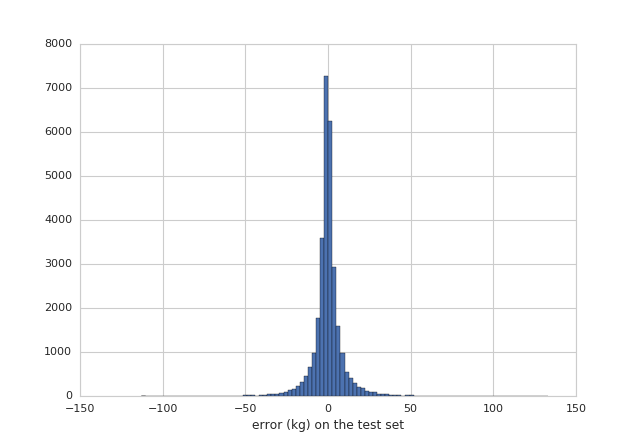

In [20]:
# the error of the m_final predictor (trained with the m_star prediction)

plt.figure()
h = plt.hist(y_test - m_final_predictor.predict(X_test), 100)
plt.xlabel("error (kg) on the test set")
plt.axes()

Lets see what would happen if, instead we predict the final mass as:

$$
m_f = m_i * exp(\frac{-\Delta V_L}{I_{sp}g_0)
$$

In [21]:
# error of the lambert model

m_final_lambert = data['m_initial'] * (1 - np.exp(-data['dv_lambert'] / I_sp / g_0))

mse = sklearn.metrics.mean_squared_error(m_final, m_final_lambert)
mae = sklearn.metrics.mean_absolute_error(m_final, m_final_lambert)

print("MAE", mae)
print("RMSE", np.sqrt(mse))

MAE 31.5793031225
RMSE 43.0455816174


In [22]:
# error of the damon model

m_final_damon = data['m_initial'] * (1 - np.exp(-data['dv_damon'] / I_sp / g_0))

mse = sklearn.metrics.mean_squared_error(m_final, m_final_damon)
mae = sklearn.metrics.mean_absolute_error(m_final, m_final_damon)

print("MAE", mae)
print("RMSE", np.sqrt(mse))

MAE 36.3930670567
RMSE 43.9426639926


<IPython.core.display.Javascript object>


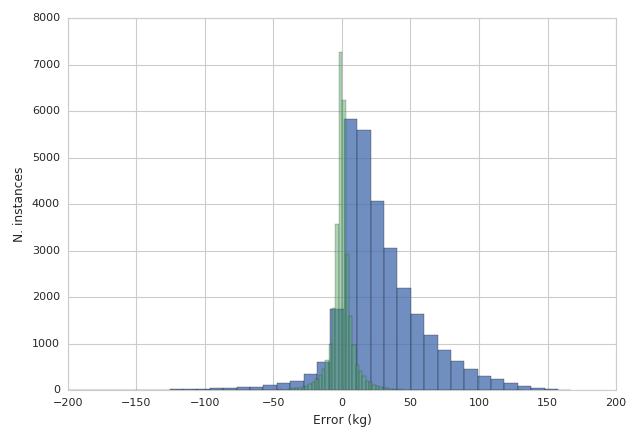

/usr/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [23]:
# plot lambert versus machine learning

m_final_lambert_test = X_test[:, -2] * (1 - np.exp(-X_test[:, 14] / I_sp / g_0))

plt.figure()
h = plt.hist(y_test - m_final_lambert_test, 100, alpha=0.8,normed=False, log=False)
h = plt.hist(y_test - m_final_predictor.predict(X_test), 100, alpha=0.5, normed=False, log=False)
plt.xlabel("Error (kg)")
plt.ylabel("N. instances")
plt.xlim(-200,200)
plt.tight_layout(1)

### Neural Network Training

In [41]:
class DeepLearningRegressor:
    def __init__(self, layers=[20, 40, 20, 10, 5], learning_rate=0.001, batch_size=16, num_epochs=500, scaler=preprocessing.StandardScaler):
        self.layers = layers
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        self.input_scaler = scaler()
        self.output_scaler = scaler()
        
        self.X_val = None
        self.y_val = None
    
    @staticmethod
    def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
        assert len(inputs) == len(targets)
        if shuffle:
            indices = np.arange(len(inputs))
            np.random.shuffle(indices)
        for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            yield inputs[excerpt], targets[excerpt]

    def fit(self, X, y, X_val=None, y_val=None):
        self.X_train = self.input_scaler.fit_transform(X)
        self.y_train = self.output_scaler.fit_transform(y.reshape((-1, 1)))
        
        if y_val is not None:
            self.X_val = self.input_scaler.transform(X_val)
            self.y_val = self.output_scaler.transform(y_val.reshape((-1, 1)))
        
        # input layer
        nn = lasagne.layers.InputLayer((None, X.shape[-1]))
        input_var = nn.input_var
        
        # hidden layers (ReLu)
        for nodes in self.layers:
            nn = lasagne.layers.DenseLayer(nn, nodes)
        
        # output layer (linear)
        nn = lasagne.layers.DenseLayer(nn, 1, nonlinearity=lasagne.nonlinearities.linear)
        
        output_var = lasagne.layers.get_output(nn)
        target_var = T.matrix('target')
        loss = lasagne.objectives.squared_error(target_var, output_var).mean()
        
        params = lasagne.layers.get_all_params(nn)
        updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=self.learning_rate)
        
        self.train_fn = theano.function([input_var, target_var], loss, updates=updates)
        self.val_fn = theano.function([input_var, target_var], loss)
        self.pred_fn = theano.function([input_var], output_var)
        
        self.train_loss = []
        self.val_loss = []
        
        self.keep_training()
    
    def keep_training(self):
        for epoch in tqdm.trange(self.num_epochs):
            train_batches = 0
            train_err = 0
            val_batches = 0
            val_err = 0

            for inputs, targets in DeepLearningRegressor.iterate_minibatches(self.X_train, self.y_train, self.batch_size, shuffle=True):
                train_err += self.train_fn(inputs, targets)
                train_batches += 1

            self.train_loss.append(train_err / train_batches)

            if self.y_val is not None:
                for inputs, targets in DeepLearningRegressor.iterate_minibatches(self.X_val, self.y_val, self.batch_size, shuffle=False):
                    val_err += self.val_fn(inputs, targets)
                    val_batches += 1

                self.val_loss.append(val_err / val_batches)
                
    def predict(self, X):
        return self.output_scaler.inverse_transform(self.pred_fn(self.input_scaler.transform(X)))
    
    def plot_loss(self):
        plt.figure()
        plt.plot(self.train_loss)
        plt.plot(self.val_loss)

In [39]:
m_nn_predictor = DeepLearningRegressor()
m_nn_predictor.fit(X_train, y_train, X_test, y_test)

# error
mse = sklearn.metrics.mean_squared_error(y_test, m_nn_predictor.predict(X_test))
mae = sklearn.metrics.mean_absolute_error(y_test, m_nn_predictor.predict(X_test))

print("MAE", mae)
print("RMSE", np.sqrt(mse))

100%|██████████| 500/500 [07:40<00:00,  1.09it/s]

MAE 4.63219372628
RMSE 9.00384543131


<IPython.core.display.Javascript object>


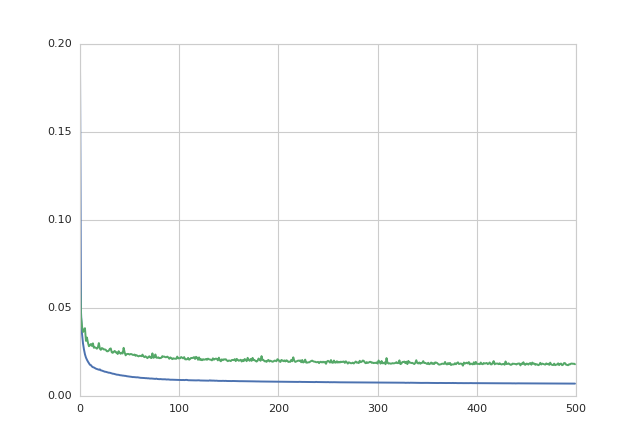

In [42]:
m_nn_predictor.plot_loss()